<a href="https://colab.research.google.com/github/OluwajobaOluwabori/Sentiment-Analysis/blob/main/Basic_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
# Import neccessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd



In [148]:
dataset = pd.read_csv('/content/combined_data.csv')
#Convert text to a list
text = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()


In [149]:
#Split into train and test sequence
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)

In [150]:
from pandas._libs.algos import pad_2d_inplace
#Tokenize the data
tokenizer=Tokenizer(oov_token='<OOV>',num_words=500)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
x_sequence = tokenizer.texts_to_sequences(X_train)
train_padded= pad_sequences(x_sequence,maxlen=50, padding= 'post' , truncating='post')

y_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(y_sequences,maxlen=50, 
                               padding='post', truncating='post')

In [151]:
#Review a Sequence
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(train_padded[2]))
print(X_train[2])

definitely not worth the 3 i <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Definitely not worth the $3 I paid.


In [152]:
## Train a Basic Sentiment Model with Embeddings
model= tf.keras.Sequential([
    tf.keras.layers.Embedding(500,16,input_length=50),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='Accuracy')
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_44 (Dense)            (None, 16)                272       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_45 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8,289
Trainable params: 8,289
Non-trainable params: 0
___________________________________________________

In [153]:
history=model.fit(train_padded,training_labels_final,epochs=30,validation_data=(testing_padded,testing_labels_final))

Epoch 1/30
50/50 [==============================] - 1s 6ms/step - loss: 1.1491 - Accuracy: 0.4915 - val_loss: 0.8134 - val_Accuracy: 0.5338
Epoch 2/30
50/50 [==============================] - 0s 3ms/step - loss: 0.7983 - Accuracy: 0.4915 - val_loss: 0.7002 - val_Accuracy: 0.5338
Epoch 3/30
50/50 [==============================] - 0s 3ms/step - loss: 0.7182 - Accuracy: 0.5267 - val_loss: 0.6843 - val_Accuracy: 0.5689
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6959 - Accuracy: 0.5443 - val_loss: 0.6822 - val_Accuracy: 0.5539
Epoch 5/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6926 - Accuracy: 0.5405 - val_loss: 0.6766 - val_Accuracy: 0.5890
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6872 - Accuracy: 0.5543 - val_loss: 0.6719 - val_Accuracy: 0.6040
Epoch 7/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6883 - Accuracy: 0.5468 - val_loss: 0.6665 - val_Accuracy: 0.6341
Epoch 8/30
50/50 [==

**Get files for visualizing the network**
The code below will download two files for visualizing how the network "sees" the sentiment related to each word. Head to http://projector.tensorflow.org/ and load the files, then click the "Sphereize" checkbox.



In [133]:
#@title
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [134]:
#@title
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 500):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [135]:
#@title
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

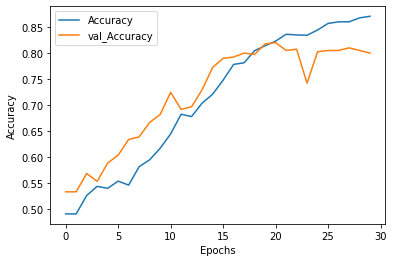

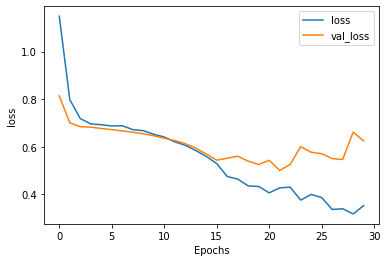

In [154]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "Accuracy")
plot_graphs(history, "loss")